In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import nibabel as nib
import scipy.stats
import matplotlib as mpl
from cmath import rect, phase
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

In [3]:
def mean_angle(rad):
    return (phase(sum(rect(1, d) for d in rad)/float(len(rad))))

In [4]:
img = nib.load('brain.nii')
data = img.get_data()

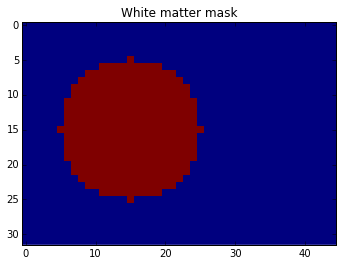

In [5]:
slice = data[:,28,:,0]

# XXX DUMMY SLICE

slice = np.zeros(slice.shape)
xx, yy = np.mgrid[:slice.shape[0], :slice.shape[1]]
x0, y0, radius = 15, 15, 10
circle = (xx - x0)**2 + (yy - y0)**2
slice = circle <= radius**2
slice = 255 * slice.astype(np.uint8)


plt.figure()
plt.imshow(slice.T, interpolation='none')
plt.title("White matter mask")

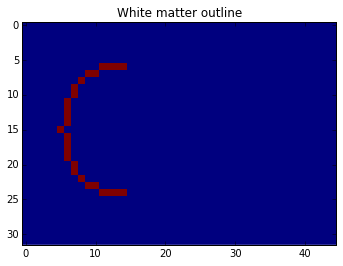

In [6]:
border  = np.zeros_like(slice)
for (i, j), val in np.ndenumerate(slice):
    if i > 0 and i < slice.shape[0] - 1 and j > 0 and j < slice.shape[1] - 1:
        if val > 0 and i < slice.shape[0]/3:
            if slice[i - 1, j] == 0 \
             or slice[i + 1, j] == 0 \
                or slice[i, j - 1] == 0 \
                or slice[i, j + 1] == 0:
                    border[i, j] = 1


plt.figure()
plt.title("White matter outline")
plt.imshow(border.T, interpolation='none')
                

In [7]:
idx = np.where(border)
n_idx = idx[0].size

In [114]:
#%debug
n_particles = 5000
max_particle_steps = 1000
voxel_scale = 1.   # scale factor between "voxel space" and "particle space"
dt = .1  # particle stepsize (in particle space)
m = 10. # particle mass
zeta = 50.  # drift strength
noise_ampl = 1.

density_map = np.zeros_like(slice, dtype=np.float)
direction_map = np.zeros_like(slice, dtype=np.complex)   # N.B. direction is stored as complex numbers (vector representation in the complex plane) to facilitate averaging
grad = [np.zeros_like(density_map), np.zeros_like(density_map)]  # gradient of the density map

start_fibres_perpendicular = False  # set to `True` for starting fibres perpendicular to the surface; `False` to generate a random direction 0..2pi

if start_fibres_perpendicular:
    wm_mask_blurred = gaussian_filter(slice, sigma=2)
    wm_gradx, wm_grady = np.gradient(wm_mask_blurred.astype(np.float))

trajectories = []

for particle_idx in range(n_particles):
    if (particle_idx + 1) % 1000 == 0:
        print("Progress: " + str(particle_idx + 1) + " out of " + str(n_particles))
    start_voxel_idx = np.random.randint(n_idx)
    start_voxel = np.array([idx[0][start_voxel_idx], idx[1][start_voxel_idx]], dtype=np.int)
    if start_fibres_perpendicular:
        initial_direction_vector = np.array([wm_gradx[start_voxel[0], start_voxel[1]], wm_grady[start_voxel[0], start_voxel[1]]])
        
        initial_direction_vector += np.array([scipy.stats.uniform(0., np.pi / 8.).rvs(), scipy.stats.uniform(0., np.pi / 8.).rvs()])
        initial_direction_vector /= np.linalg.norm(initial_direction_vector)
    else:
        initial_direction_ang = scipy.stats.uniform(0., 2 * np.pi).rvs()
        initial_direction_vector = np.array([np.cos(initial_direction_ang), np.sin(initial_direction_ang)])

    #
    #   simulate particle trajectory
    #

    particle_trajectory = []
    particle_trajectory_voxel = []

    pos = np.array([0., 0.])  # relative position of the particle (i.e. w.r.t. (0, 0))
    vel = np.array([initial_direction_vector[0], initial_direction_vector[1]])  # velocity vector of the particle, always unit length
    for i in range(max_particle_steps):

        voxel_pos = np.round(voxel_scale * pos).astype(np.int) + start_voxel
        
        #
        #  termination condition: particle exited WM mask
        #
        
        if voxel_pos[0] < 0 or voxel_pos[0] >= slice.shape[0] \
         or voxel_pos[1] < 0 or voxel_pos[1] >= slice.shape[1] \
         or slice[tuple(voxel_pos)] == 0:
            break

            
        #
        #  logging
        #

        particle_trajectory.append(np.copy(pos))
        particle_trajectory_voxel.append(np.copy(voxel_pos))

        
        #
        #  update state
        #
        
        if particle_idx > 1 and (particle_idx + 1) % 100 == 0:
                # recompute gradient of the density map
                _density_map = density_map / np.amax(density_map)
                grad = np.gradient(gaussian_filter(_density_map, sigma=2))
            
        gradient_vec = np.array([grad[0][tuple(voxel_pos)], grad[1][tuple(voxel_pos)]])                

        noise = noise_ampl * scipy.stats.norm(0., 1.).rvs(2)
        dpos = vel
        dvel = (-zeta * gradient_vec + noise) / m

        pos += dt * dpos
        vel += dt * dvel
        vel /= np.linalg.norm(vel)
        
        
    trajectories.append(particle_trajectory_voxel)

    if i > 1 and len(np.unique(particle_trajectory_voxel)) > 1:
        for i in range(1, len(particle_trajectory_voxel)):
            direction_vec = np.array([particle_trajectory[i][0] - particle_trajectory[i-1][0], particle_trajectory[i][1] - particle_trajectory[i-1][1]])
            density_map[tuple(particle_trajectory_voxel[i])] += 1.

            if np.linalg.norm(direction_vec) > 0.:
                direction_vec /= np.linalg.norm(direction_vec)
                direction_ang = np.arctan2(direction_vec[1], direction_vec[0])
                if direction_ang < 0.:
                    direction_ang += np.pi
                direction_map[tuple(particle_trajectory_voxel[i])] += rect(1, direction_ang)
        
#
#   convert direction back from complex format to angle
#

direction_map_ang = np.empty_like(slice, dtype=np.float)
for (i, j), _ in np.ndenumerate(direction_map):
    direction_map_ang[i, j] = np.abs(np.pi-phase(direction_map[i, j]))
    # density /= float(n_particles)

Progress: 1000 out of 5000
Progress: 2000 out of 5000
Progress: 3000 out of 5000
Progress: 4000 out of 5000
Progress: 5000 out of 5000


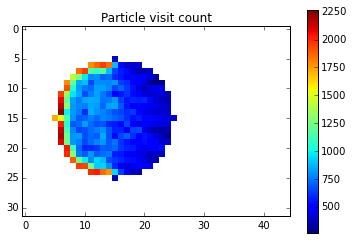

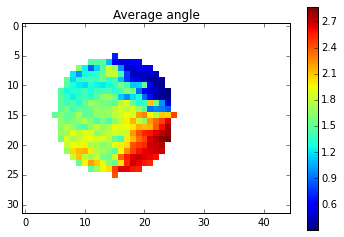

In [115]:
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

if n_particles <= 100:
    plt.figure()
    masked_array = np.ma.array(density_map, mask=255 - slice)
    plt.imshow(masked_array.T, interpolation="none")
    plt.title("Particle visit count + trajectories")
    for particle_idx in range(n_particles):
        _traj = np.array(trajectories[particle_idx])
        plt.plot(_traj[:, 0], _traj[:, 1], "o-")
    plt.colorbar()

plt.figure()
masked_array = np.ma.array(density_map, mask=255 - slice)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Particle visit count")
plt.colorbar()

#cmap = plt.cm.hsv
#cmap.set_bad('w', 1.)
#norm = mpl.colors.Normalize(vmin=0., vmax=np.pi)
norm = None

plt.figure()
masked_array = np.ma.array(direction_map_ang, mask=255 - slice)
plt.imshow(masked_array.T, interpolation='none', cmap=cmap, norm=norm)
plt.title("Average angle")
plt.colorbar()


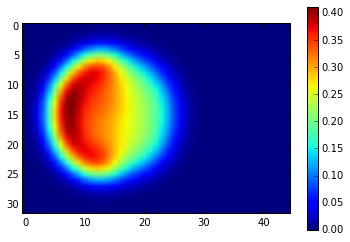

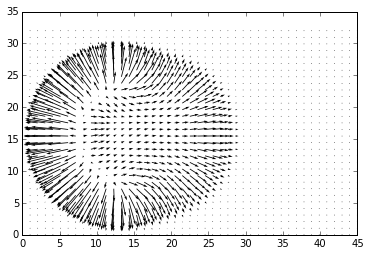

In [116]:
_density_map = density_map / np.amax(density_map)
grad = np.gradient(gaussian_filter(_density_map, sigma=2))

plt.figure()
plt.imshow(gaussian_filter(_density_map, sigma=2).T)
plt.colorbar()

plt.figure()
X, Y = np.meshgrid(np.linspace(0, _density_map.shape[0], _density_map.shape[0]), np.linspace(0, _density_map.shape[1], _density_map.shape[1]))
plt.quiver(X.T, Y.T, -grad[0], -grad[1])

In [43]:
X.shape, grad[0].shape


((32, 45), (45, 32))

In [46]:
Y

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.03225806,   1.03225806,   1.03225806, ...,   1.03225806,
          1.03225806,   1.03225806],
       [  2.06451613,   2.06451613,   2.06451613, ...,   2.06451613,
          2.06451613,   2.06451613],
       ..., 
       [ 29.93548387,  29.93548387,  29.93548387, ...,  29.93548387,
         29.93548387,  29.93548387],
       [ 30.96774194,  30.96774194,  30.96774194, ...,  30.96774194,
         30.96774194,  30.96774194],
       [ 32.        ,  32.        ,  32.        , ...,  32.        ,
         32.        ,  32.        ]])